# Problems with visualizing data on curvilinear horizontal grids

In [1]:
import netCDF4
import numpy
import matplotlib.pyplot as plt

# These two packages will be used for illustrating the an inefficient cell-by-cell plotting approach
import matplotlib.patches
import matplotlib.collections

Above I have imported the packages we encountered already which you will likely use often. The last two imports you will not often need and I import them here for the purposes of the following discussion.

Let's look at some model output that resides on the native curvilinear grid of the model.

In [2]:
nc = netCDF4.Dataset('http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/MIROC/MIROC6/1pctCO2/r1i1p1f1/Omon/tos/gn/v20181212/tos_Omon_MIROC6_1pctCO2_r1i1p1f1_gn_330001-334912.nc')

which contains the variables

In [3]:
print( nc.variables.keys() )

odict_keys(['time', 'time_bnds', 'y', 'y_bnds', 'x', 'x_bnds', 'vertices_latitude', 'vertices_longitude', 'latitude', 'longitude', 'tos'])


This is a CMIP6 file and so contains only one model dynamic variable per file (here 'tos' is CMIP lingo for "Temperature of Ocean Surface") so all the other variables listed are forms of coordinates. Why so many? That is unfortunately part of the convention which is poorly designed for data on curvilinear meshes.



Here is a list of the variables with their symbolic netcdf dimensions and their actual shape:

In [4]:
for v in nc.variables:
    print('{:21} dimensions = {!s:25} shape = {!s}'.format(v, nc.variables[v].dimensions, nc.variables[v].shape))

time                  dimensions = ('time',)                 shape = (600,)
time_bnds             dimensions = ('time', 'bnds')          shape = (600, 2)
y                     dimensions = ('y',)                    shape = (256,)
y_bnds                dimensions = ('y', 'bnds')             shape = (256, 2)
x                     dimensions = ('x',)                    shape = (360,)
x_bnds                dimensions = ('x', 'bnds')             shape = (360, 2)
vertices_latitude     dimensions = ('y', 'x', 'vertices')    shape = (256, 360, 4)
vertices_longitude    dimensions = ('y', 'x', 'vertices')    shape = (256, 360, 4)
latitude              dimensions = ('y', 'x')                shape = (256, 360)
longitude             dimensions = ('y', 'x')                shape = (256, 360)
tos                   dimensions = ('time', 'y', 'x')        shape = (600, 256, 360)


There are five netcdf dimensions:

- 'x', 'y' and 'time', are the shape of the data.
  - 'time' is model time, usually given as a days since a date.
  - 'x' and 'y' is a "model" coordinate and __NOT__ geographic longitude and latitude, even if the units and values make it seem so.
- 'bnds' and 'verticies' are two other dimensions needed to provide extra information to deal with the deficiency of the data storage designed for providing data at locations rather than on finite volume mesh.
  - 'bnds' is equal to 2 and is used in the *_bnds variables.
  - 'vertices' is equal to 4 (this is a quadrilateral mesh) and used to provide the latitude and longitude of the corners of each cell.

Let's quickly look at the first time-slice of the variable of interest

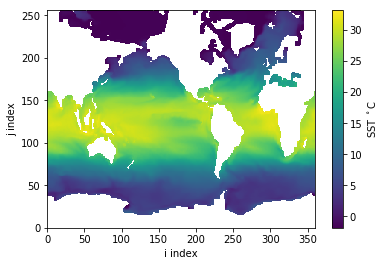

In [5]:
tos = nc.variables['tos'][0] # Pre-load data which will be re-used later

plt.pcolormesh( tos ); # Plotting without coordinate (for now)

plt.colorbar(label='SST $^\circ$C')
plt.xlabel('i index');
plt.ylabel('j index');

At first glance this looks like the planet's ocean _but_ notice how Canada and Northern Russia reach the top edge? This data resides on a tri-polar curvilinear mesh so the Northern hemisphere is highly distorted if plotted naively (as done here).

What about those 1-dimensional coordinate variables 'x' and 'y'? Let's try them...

In [6]:
print( nc.variables['x'] )
print( nc.variables['y'] )

<class 'netCDF4._netCDF4.Variable'>
float64 x(x)
    bounds: x_bnds
    units: degrees
    axis: X
    long_name: x coordinate of projection
    standard_name: projection_x_coordinate
unlimited dimensions: 
current shape = (360,)
filling off

<class 'netCDF4._netCDF4.Variable'>
float64 y(y)
    bounds: y_bnds
    units: degrees
    axis: Y
    long_name: y coordinate of projection
    standard_name: projection_y_coordinate
unlimited dimensions: 
current shape = (256,)
filling off



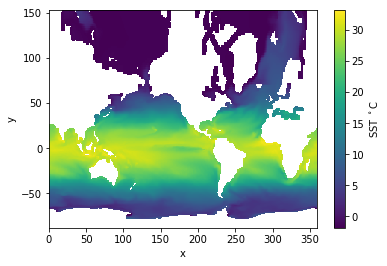

In [7]:
plt.pcolormesh( nc.variables['x'][:], nc.variables['y'][:], tos ); # Plotting with "projection coordinate"

plt.colorbar(label='SST $^\circ$C')
plt.xlabel('x');
plt.ylabel('y');

Using the "projection coordinate" has merely stretched things out. In principle, if we had code to map from a projection coordinate to geographic longitude and latitude then we could plot properly.

_Comment: Model meshes rarely use analytic projections but normally have numerically generated meshes so the notion of a providing projection coordinates for the user is somewhat useless in practice._

The file also contains the geographic coordinates "longitude" and "latitude" which are each 2D data. Note that they have the same shape as each time-level of "tos" which means it will suffer from the missing row/column problem mention previously.

In [8]:
# Pre-load data which will be re-used later
lon = nc.variables['longitude'][:]
lat = nc.variables['latitude'][:]

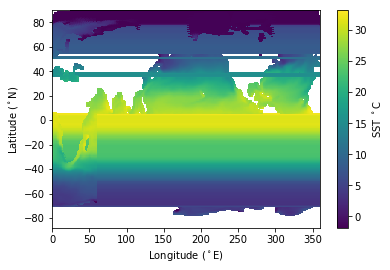

In [9]:
plt.pcolormesh(lon, lat, tos)

plt.colorbar(label='SST $^\circ$C')
plt.xlabel('Longitude ($^\circ$E)');
plt.ylabel('Latitude ($^\circ$N)');

Obviously this didn't work well! I'll explain what's going wrong later but first we know should be using the mesh coordinates (cell corners) rather data coordinates (cell centers) so let's try that.

Before moving onto using the actual mesh coordinates that are provided, a brief explanation about cell bounds versus coordinates. 'x_bnds' are the cell bounds for the 'x' coordinate variable:

In [10]:
nc.variables['x_bnds']

<class 'netCDF4._netCDF4.Variable'>
float64 x_bnds(x, bnds)
    _ChunkSizes: [360   2]
unlimited dimensions: 
current shape = (360, 2)
filling off

In [11]:
print( nc.variables['x'][:5] )

[0.5 1.5 2.5 3.5 4.5]


In [12]:
print( nc.variables['x_bnds'][:5] )

[[0. 1.]
 [1. 2.]
 [2. 3.]
 [3. 4.]
 [4. 5.]]


We see that the first five values of 'x' are monotonically increasing and that each value of 'x' falls in between the bounds of the cell 'x_bnds'.

_Comment: There is redundancy in the 'x__bnds' data. There are 360 x 2 = 720 data values but only 361 distinct values because the cells are space-filling or contiguous - the right edge of one cell is the left edge of the next. The data could have been more compactly stored as a one dimensional list of 361 values. For efficient plotting in two dimensions, the more compact coordinate data will prove more useful._

Now look at the geographic longitude and the associated vertex data:

In [13]:
print( nc.variables['longitude'] )

<class 'netCDF4._netCDF4.Variable'>
float32 longitude(y, x)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    missing_value: 1e+20
    _FillValue: 1e+20
    bounds: vertices_longitude
    _ChunkSizes: [256 360]
unlimited dimensions: 
current shape = (256, 360)
filling off



In [14]:
print( nc.variables['vertices_longitude'] )

<class 'netCDF4._netCDF4.Variable'>
float32 vertices_longitude(y, x, vertices)
    units: degrees_east
    missing_value: 1e+20
    _FillValue: 1e+20
    _ChunkSizes: [256 360   4]
unlimited dimensions: 
current shape = (256, 360, 4)
filling off



Analogous to how pairs of 'x_bnd' reflect the cells surronding 'x', quads of 'vertices_longitude' describe the cells centered on 'longitude'. The same will be true for 'vertices_latitude' and 'latitude'. Here's some actual values for cell with index j=7,i=3:

In [15]:
print( 'Longitude =', nc.variables['longitude'][7,3], 'Latitude =', nc.variables['latitude'][7,3] )

Longitude = 63.5 Latitude = -82.75


In [16]:
print( nc.variables['vertices_longitude'][7,3,:], nc.variables['vertices_latitude'][7,3,:] )

[63. 64. 64. 63.] [-83.  -83.  -82.5 -82.5]


Again we see that for a particular cell the longitude,latitude coordinates fall within the bounds of the cells given as the cell vertices.

Observe that the vertices are given in an anti-clockwise order starting in the south-west (bottom-left) corner. We will later use this to construct a more compact mesh description.

The next two cells of this notebook use the vertex data to plot a polygon for each cell of data. __THIS IS NOT THE RECOMMENDED WAY TO PLOT__ but is provided to show how tedious it is to use the mesh information in this format, _and_ to illustrate some problems with the curvilinear mesh itself.

In [17]:
# For efficiency, load relevant data into memory 
vlon = nc.variables['vertices_longitude'][:]
vlat = nc.variables['vertices_latitude'][:]

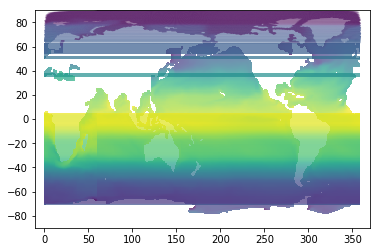

In [18]:
# A tedious way to plot, cell-by-cell
fig, ax = plt.subplots();
plt.xlim(-10,370);
plt.ylim(-90,90);
patches = []; vals = []
for j in range(nc.variables['y'].shape[0]):
    for i in range(nc.variables['x'].shape[0]):
        if not tos.mask[j,i]:
            llon = vlon[j,i,:]
            llat = vlat[j,i,:]
            xy = numpy.vstack([llon,llat])
            patches.append( matplotlib.patches.Polygon(xy.T) )
            vals.append( tos[j,i] )
p = matplotlib.collections.PatchCollection( patches, alpha=0.7)
p.set_array( numpy.array(vals) )
ax.add_collection(p);

You might notice this took a while to plot - plotting cell-by-cell is very inefficient.

And despite all that code, the plot still looks no better than the `plt.pcolormesh(lon, lat, tos)` we tried above.

Here, I used a partially transparent "alpha" so you can see the continent outline. The continents are being overdrawn by cells whose longitudes "wrap around" from 360 to 0 and so span the entire plot. The longitudes in this mesh appear to be constrained to the range 0..360.

To see what is going wrong, here's the longitude,latitude (on the same vertical scale) for the NE vertex of cells at a constant j-index (of 190):

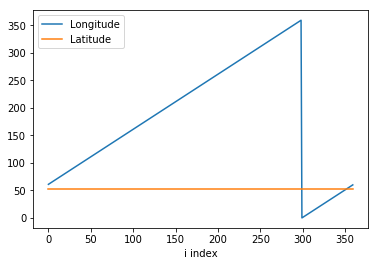

In [19]:
plt.plot( vlon[190,:,2], label='Longitude' );
plt.plot( vlat[190,:,2], label='Latitude' );
plt.xlabel('i index');
plt.legend();

The latitudes are constant (for this j-index) and the longitudes increase linearly until about 360 where they jump down to near zero before increasing again. This is the periodicity of the longitudinal coordinate being manifest. 360 degrees east is equivalent to 0 degree east on the sphere but not on our 2D plots. So long as we are making the plots ourselves (as opposed to using a mapping package) we need to fix the coordinates.

Here's how we can try.

We'll make the following assumptions:
- Starting vertex is the same for each cell (in this dataset it is the SW corner).
- Direction of vertexes is the same for all cells (in this dataset it is counter-clockwise).

And we will make the following adjustments:
- Create contiguous coordinate arrays for mesh vertexes without redundancy.
- Adjust longitudes to not decrease with increasing i-index so as to not cross previous patches

In [20]:
# First create the latitude array for the mesh (which needs no value adjustments)
flat = numpy.zeros( (nc.variables['y'].shape[0]+1, nc.variables['x'].shape[0]+1) ) # 1 larger than cell shape
flat[1:,1:] = vlat[:,:,2] # Copy NE corner values to mesh
flat[0,1:] = vlat[0,:,1] # Copy SE corner for bottom row only
flat[1:,0] = vlat[:,0,3] # Copy NW corner for left column only
flat[0,0] = vlat[0,0,0] # Copy SW corner for SW cell only

In [21]:
# Now create the longitude array for the mesh
flon = numpy.zeros( (nc.variables['y'].shape[0]+1, nc.variables['x'].shape[0]+1) )
flon[1:,1:] = vlon[:,:,2] # Copy NE corner values to mesh
flon[0,1:] = vlon[0,:,1] # Copy SE corner for bottom row only
flon[1:,0] = vlon[:,0,3] # Copy NW corner for left column only
flon[0,0] = vlon[0,0,0] # Copy SW corner for SW cell only

# The following lines "fix" the longitude values so plotting works
for i in range(nc.variables['x'].shape[0]):
    dlon = flon[:,i+1] - flon[:,i]
    dlon = numpy.mod( dlon, 360)
    flon[:,i+1] = flon[:,i] + dlon # Monotonically increase
flon[-1,:] = numpy.round( (flon[-2,:]-60)/180 )*180+60 # Top row of longitudes need special values!

Here, I made sure that longitude increase monotonically in the i-direction.

The following plots cell-by-cell with the adjusted coordinates... (__still not recommended as a plotting approach__).


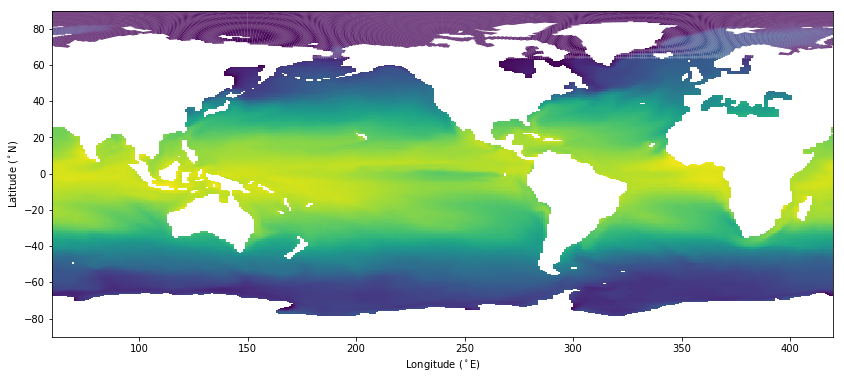

In [22]:
# Still a tedious way to plot, cell-by-cell
fig, ax = plt.subplots(figsize=(14,6));
plt.xlim(60,420);
plt.ylim(-90,90);
patches = []; vals = []
for j in range(nc.variables['y'].shape[0]):
    for i in range(nc.variables['x'].shape[0]):
        if not tos.mask[j,i]:
            llon = numpy.array([flon[j,i], flon[j,i+1], flon[j+1,i+1], flon[j+1,i]])
            llat = numpy.array([flat[j,i], flat[j,i+1], flat[j+1,i+1], flat[j+1,i]])
            xy = numpy.vstack([llon,llat])
            patches.append( matplotlib.patches.Polygon(xy.T) )
            vals.append( tos[j,i] )
p = matplotlib.collections.PatchCollection( patches, alpha=1)
p.set_array( numpy.array(vals) )
ax.add_collection(p);

plt.xlabel('Longitude ($^\circ$E)');
plt.ylabel('Latitude ($^\circ$N)');

The mis-coloring in the Arctic is a plotting artifact of the polygons, not a coordinate problem.

_Comment: There is no color bar shown because the code to create a color scale for the polygon shading requries too much code and would be obviscating._

Here's the same plot but now using `pcolormesh()` that is much much more efficient (and is artifact free).

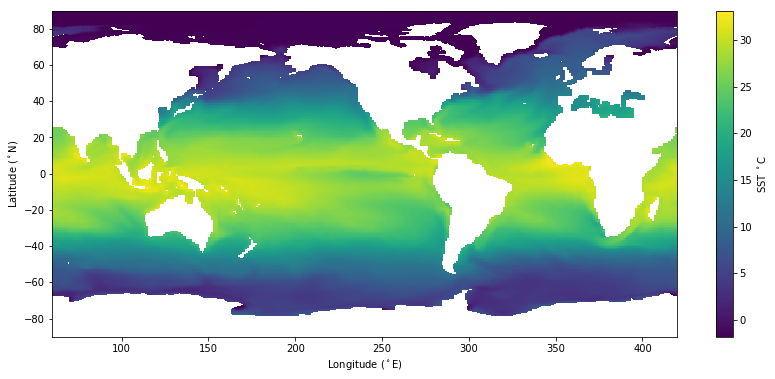

In [23]:
# A much quicker way to make the same plot
plt.figure(figsize=(14,6))

plt.pcolormesh( flon, flat, tos);

plt.colorbar(label='SST $^\circ$C')
plt.xlabel('Longitude ($^\circ$E)');
plt.ylabel('Latitude ($^\circ$N)');

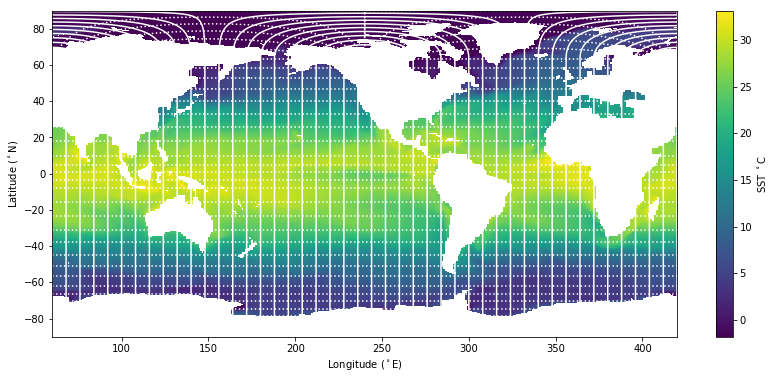

In [24]:
# As above but with the mesh over drawn
plt.figure(figsize=(14,6))

plt.pcolormesh( flon, flat, tos);

plt.colorbar(label='SST $^\circ$C')
plt.xlabel('Longitude ($^\circ$E)');
plt.ylabel('Latitude ($^\circ$N)');

plt.plot( flon[:,::8], flat[:,::8], 'w-'); # Lines of constant i-index
plt.plot( flon[::8,:].T, flat[::8,:].T, 'w:'); # Lines of constant j-index

## Comments

- "Fixing the coordinates" so that plotting works took two steps: i) extracting a compact set of coordinate data and ii) correcting values that can be plotted without over-drawing of data.
- The latter problem is a result of trying to plot spherical data on a 2D plane. This will be better dealt with using projections of the sphere onto a plane for which the cartopy package is designed (see next notebook).
- The reshaping of coordinate data is a necessary step because the CMOR file format is poorly designed. We will continue to reshape the vertex data in subsequent examples.